In [1]:
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import numpy as np

from sklearn.cluster import KMeans

In [2]:
from gensim.models import KeyedVectors
model_dir = 'wiki-news-300d-1M.vec'
model = KeyedVectors.load_word2vec_format(model_dir, binary=False)

In [10]:
inputfile="230707_6.csv"

In [21]:
data=pd.read_csv(f"{inputfile}")

interaction_array=np.array(data['interactions'])
interaction_with_array=np.array(data['target_obj'])
action_array=np.array(data['action'])

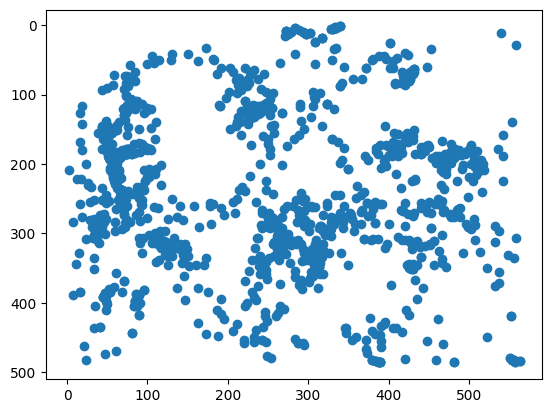

In [22]:
plt.gca().invert_yaxis()  # y軸を反転する
plt.scatter(data.loc[:, ['x']], data.loc[:, ['y']])

In [23]:
data

,time,x,y,action,interactions,target_obj
0,2023-07-07 19:40:40.237731,372,62,walking,none,none
1,2023-07-07 19:40:40.444592,372,62,walking,none,none
2,2023-07-07 19:40:40.856336,340,88,walking,none,none
3,2023-07-07 19:40:41.061566,340,88,walking,none,none
4,2023-07-07 19:40:41.268791,324,114,walking,none,none
...,...,...,...,...,...,...
1279,2023-07-07 19:46:16.839170,48,256,walking,none,none
1280,2023-07-07 19:46:17.043681,50,254,walking,none,none
1281,2023-07-07 19:46:17.248100,26,231,walking,none,none
1282,2023-07-07 19:46:17.454960,12,221,walking,none,none


In [24]:
data = data[(data['action'] != 'walking') | (data['interactions'] != 'none')]

In [25]:
data2=data.loc[:,['x','y']]

In [26]:
data2

,x,y
12,373,256
13,373,256
14,383,285
15,383,285
16,401,287
...,...,...
1252,217,93
1256,217,158
1277,91,282
1278,71,272


In [27]:
data3 = [list(e) for e in zip(data['x'],data['y'])]

In [28]:
data3

[[373, 256],
 [373, 256],
 [383, 285],
 [383, 285],
 [401, 287],
 [421, 290],
 [431, 275],
 [496, 287],
 [499, 291],
 [502, 294],
 [508, 310],
 [514, 327],
 [522, 350],
 [532, 376],
 [552, 419],
 [552, 419],
 [523, 449],
 [331, 6],
 [331, 6],
 [329, 6],
 [329, 6],
 [335, 4],
 [335, 4],
 [339, 2],
 [339, 2],
 [339, 2],
 [284, 4],
 [284, 4],
 [275, 13],
 [275, 13],
 [297, 13],
 [297, 13],
 [297, 13],
 [279, 10],
 [279, 10],
 [394, 431],
 [380, 441],
 [405, 437],
 [372, 453],
 [390, 464],
 [461, 424],
 [471, 349],
 [443, 379],
 [391, 434],
 [433, 367],
 [426, 417],
 [409, 436],
 [417, 442],
 [467, 337],
 [463, 326],
 [453, 292],
 [477, 272],
 [486, 265],
 [453, 293],
 [477, 274],
 [485, 267],
 [481, 276],
 [467, 303],
 [457, 311],
 [457, 311],
 [441, 334],
 [441, 334],
 [435, 345],
 [430, 344],
 [425, 344],
 [428, 346],
 [431, 348],
 [426, 345],
 [427, 348],
 [428, 351],
 [426, 349],
 [423, 346],
 [431, 352],
 [431, 352],
 [467, 343],
 [457, 345],
 [426, 350],
 [395, 427],
 [373, 473],
 [

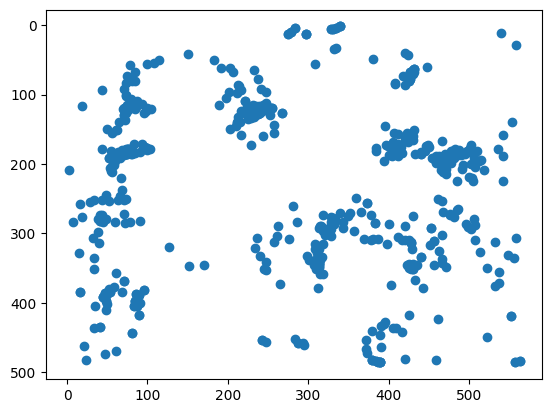

In [29]:
# data=pd.read_csv("20230623.csv")
plt.gca().invert_yaxis()  # y軸を反転する
plt.scatter(data.loc[:, ['x']], data.loc[:, ['y']])

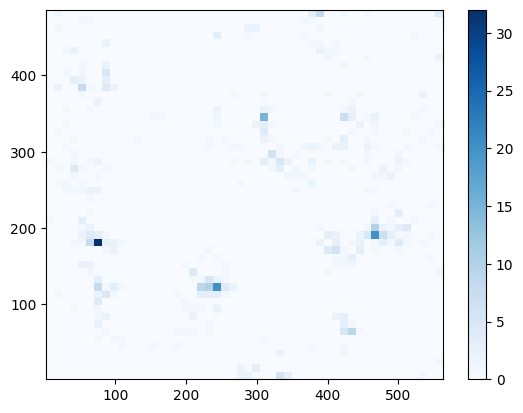

In [30]:
# data=pd.read_csv("20230623.csv")
plt.hist2d(data['x'], data['y'], bins=50, cmap='Blues')
plt.colorbar()
plt.show()

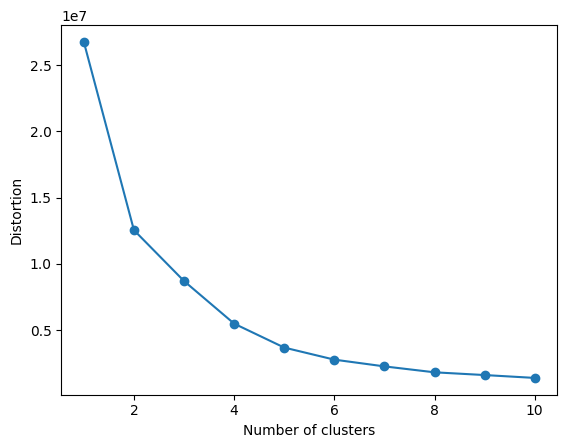

In [31]:
#elbow
distortions = []

for i in range(1,11):                 
    km = KMeans(n_clusters=i,
                init='k-means++',     
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(data3)                        
    distortions.append(km.inertia_)   

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [32]:
N=4

In [33]:
km = KMeans(n_clusters=N, random_state=42)
label = km.fit_predict(data2[:])

In [34]:
label

array([1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

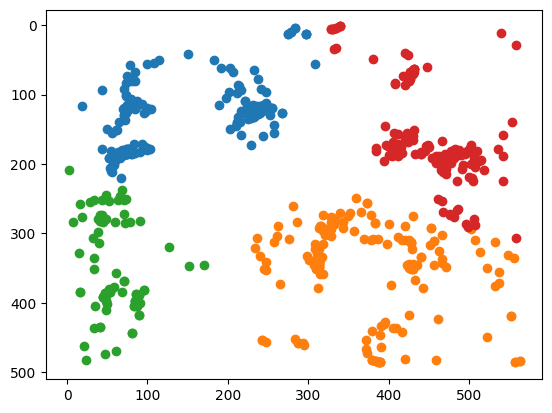

In [35]:
plt.gca().invert_yaxis()  # y軸を反転する
for i in range(N):
    plt.scatter(data.loc[:, ['x']][label==i], data.loc[:, ['y']][label==i])
# plt.scatter(data.loc[:, ['z']][label==0], data.loc[:, ['x']][label==0])
# plt.scatter(data.loc[:, ['z']][label==1], data.loc[:, ['x']][label==1])
# plt.scatter(data.loc[:, ['z']][label==2], data.loc[:, ['x']][label==2])
# plt.scatter(data.loc[:, ['z']][label==3], data.loc[:, ['x']][label==3])
plt.show()

[0.37396723, 0.34527385, 0.4979509, 0.25430954]
[0.52210647, 0.38132122, 0.3727542, 0.55331856]
[0.38037133, 0.5021895, 0.28146037, 0.28920233]
[0.5089558, 0.38817653, 0.33308622, 0.31937277]


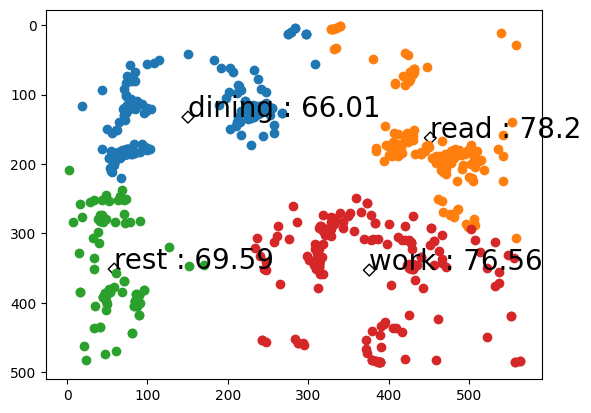

In [24]:
dd1=data.loc[:, ['y']][label==0]
ddList1 = dd1["y"].index.to_list()
dd2=data.loc[:, ['y']][label==1]
ddList2 = dd2["y"].index.to_list()
dd3=data.loc[:, ['y']][label==2]
ddList3 = dd3["y"].index.to_list()
dd4=data.loc[:, ['y']][label==3]
ddList4 = dd4["y"].index.to_list()

observedList1 =[]
for i in ddList1:
    if(interaction_array[i]!="none"):
        observedList1.append(interaction_array[i])
        if(action_array[i]=="laying"):
            observedList1.append(action_array[i])
        observedList1.append(interaction_with_array[i])

observedList2 =[]
for i in ddList2:
    if(action_array[i]=="laying"):
            observedList2.append(action_array[i])
    if(interaction_array[i]!="none"): 
        observedList2.append(interaction_array[i])
        observedList2.append(interaction_with_array[i]) 

observedList3 =[]
for i in ddList3:
    if(action_array[i]=="laying"):
            observedList3.append(action_array[i])
    if(interaction_array[i]!="none"):
        observedList3.append(interaction_array[i])
        observedList3.append(interaction_with_array[i])

observedList4 =[]
for i in ddList4:
    if(action_array[i]=="laying"):
            observedList4.append(action_array[i])
    if(interaction_array[i]!="none"):
        observedList4.append(interaction_array[i])
        observedList4.append(interaction_with_array[i])

split_values = []
original_values = []
for item in observedList1:
    split_items = item.split(',')
    split_values.extend(split_items)
    original_values.extend([item] * len(split_items))

split_values2 = []
original_values2 = []
for item in observedList2:
    split_items = item.split(',')
    split_values2.extend(split_items)
    original_values2.extend([item] * len(split_items))

split_values3 = []
original_values3 = []
for item in observedList3:
    split_items = item.split(',')
    split_values3.extend(split_items)
    original_values3.extend([item] * len(split_items))

split_values4 = []
original_values4 = []
for item in observedList4:
    split_items = item.split(',')
    split_values4.extend(split_items)
    original_values4.extend([item] * len(split_items))

centers = km.cluster_centers_
plt.gca().invert_yaxis()  # y軸を反転する
plt.scatter(centers[:, 0], centers[:, 1], marker="D", facecolors='none', edgecolors='black')
observed_lists = [split_values, split_values2, split_values3, split_values4]
utilization_class_list = ['work','rest','dining','read']
utilization = 'none'

for i, observed_list in enumerate(observed_lists):
    score = [np.mean([model.similarity(utilization, observe) for observe in observed_list]) 
             for utilization in utilization_class_list]
    max_socre = np.max(score)

    similar_list = model.most_similar(f"{utilization}")
    most_similar_score =similar_list[0][1]
    prob = max_socre / most_similar_score *100

    max_index = np.argmax(score)
    print(score)
    utilization = utilization_class_list[max_index]
    plt.scatter(data.loc[:, ['x']][label==i], data.loc[:, ['y']][label==i])
    if prob>50:
        plt.text(centers[i][0], centers[i][1], f"{utilization} : {round(prob, 2)}", fontsize=20)
    else:
        plt.text(centers[i][0], centers[i][1], f"unknown", fontsize=20)
    

In [ ]:
split_values=split_values #1 2 work  3laying 4read
total_count = len(split_values)  # split_valuesリストの総要素数
# count1 = sum(1 for value in split_values if value == "reading")  # "reading"の数をカウント
# count2 = sum(1 for value in split_values if value == "book")  # "book"の数をカウント

# count1 = sum(1 for value in split_values if value == "eating")  # "reading"の数をカウント
count2 = sum(1 for value in split_values if value == "food")  # "book"の数をカウント
count1 = sum(1 for value in split_values if value == "drinking")  # "reading"の数をカウント
# count2 = sum(1 for value in split_values if value == "food")  # "book"の数をカウント



# count1 = sum(1 for value in split_values if value == "working")  # "reading"の数をカウント
# count2 = sum(1 for value in split_values if value == "keyboard")  # "book"の数をカウント

count1_percentage = (count1 / total_count) * 100  # "reading"の含有率を計算
count2_percentage = (count2 / total_count) * 100  # "book"の含有率を計算

print(f"Reading Percentage: {count1_percentage+count2_percentage:.2f}%")

# count1 = sum(1 for value in split_values if value == "laying")  # "reading"の数をカウント

# count1_percentage = (count1 / total_count) * 100  # "reading"の含有率を計算
# print(f"Reading Percentage: {count1_percentage:.2f}%")

Reading Percentage: 43.75%


[0.37396723, 0.34527385, 0.4979509, 0.25430954]
[0.5089558, 0.38817653, 0.33308622, 0.31937277]
[0.38037133, 0.5021895, 0.28146037, 0.28920233]
[0.52210647, 0.38132122, 0.3727542, 0.55331856]


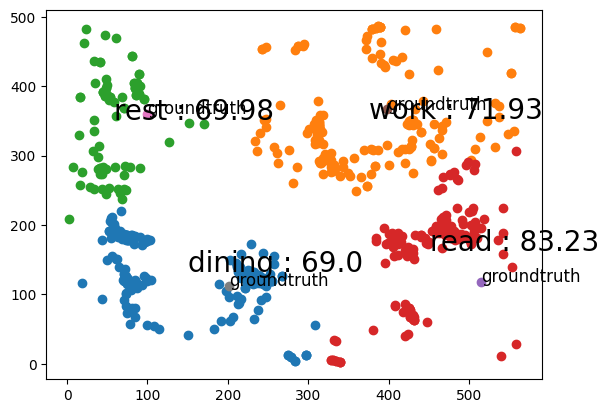

In [ ]:
for i, observed_list in enumerate(observed_lists):
    score = [np.mean([model.similarity(utilization, observe) for observe in observed_list]) 
             for utilization in utilization_class_list]
    max_socre = np.max(score)

    similar_list = model.most_similar(f"{utilization}")
    most_similar_score =similar_list[0][1]
    prob = max_socre / most_similar_score *100

    max_index = np.argmax(score)
    print(score)
    utilization = utilization_class_list[max_index]
    plt.scatter(data.loc[:, ['x']][label==i], data.loc[:, ['y']][label==i])
    if prob>50:
        plt.text(centers[i][0], centers[i][1], f"{utilization} : {round(prob, 2)}", fontsize=20)
    else:
        plt.text(centers[i][0], centers[i][1], f"unknown", fontsize=20)

points = [(515, 118), (398, 366.5), (100, 360), (202, 112)]
labels = ["groundtruth"] * len(points)

for point, label in zip(points, labels):
    plt.scatter(point[0], point[1])
    
    plt.text(point[0], point[1], label, fontsize=12)

/Users/haruhiro/opt/anaconda3/envs/mp4/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 23450 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/haruhiro/opt/anaconda3/envs/mp4/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 32681 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/haruhiro/opt/anaconda3/envs/mp4/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/haruhiro/opt/anaconda3/envs/mp4/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12383 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/haruhiro/opt/anaconda3/envs/mp4/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12463 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/User

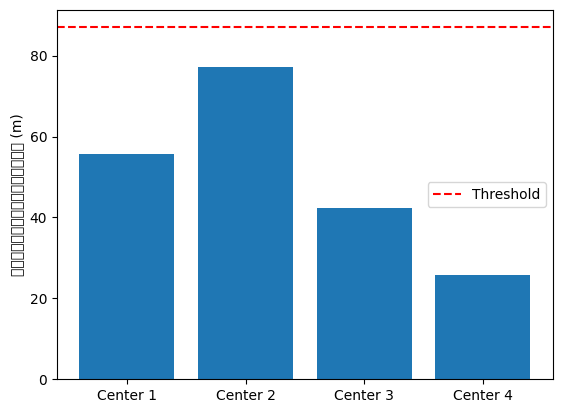

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 与えられた4つの座標
target_coordinates = np.array([(515, 118), (398, 366.5), (100, 360), (202, 112)])

# centersの座標
centers_coordinates = np.array(centers)

# 各centerと最も近い座標のインデックスを計算
nearest_indices = np.argmin(np.linalg.norm(centers_coordinates[:, None] - target_coordinates, axis=2), axis=1)

# 最も近い座標との距離を計算
distances = np.linalg.norm(centers_coordinates - target_coordinates[nearest_indices], axis=1)

# 閾値の設定
threshold = 87

# 棒グラフの描画
plt.bar(range(len(distances)), distances)

# 閾値をプロット
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')

# グラフの軸ラベルやタイトルを設定
plt.ylabel('定義したクラスタの中心からの距離 (m)', fontname ='MS Gothic')

# 距離が閾値を超える場合にテキストを追加
for i, distance in enumerate(distances):
    if distance > threshold:
        plt.text(i, distance, f"定義したクラスタの中心からの距離 (m): {distance:.2f}", ha='center', va='bottom', fontsize=10)

plt.xticks(range(len(distances)), ['Center 1', 'Center 2', 'Center 3', 'Center 4'])
plt.legend()

# グラフの表示
plt.show()


In [83]:
similar_list = model.most_similar('work')
for similar_set in similar_list:
    print(str(similar_set[0])+ " : " + str(similar_set[1]))

works : 0.717581570148468
working : 0.6682043671607971
job : 0.6681519746780396
Work : 0.642331063747406
work. : 0.6332440972328186
research : 0.6295222640037537
work- : 0.6242907047271729
doing : 0.6225779056549072
effort : 0.6146255731582642
work-- : 0.6137425303459167


In [9]:
wordsList = ["keyboard", "cellphone", "bottle", "book", "carpet", "cushion", "food", "monitor","sitting", "standing", "walking", "drinking", "reading", "calling", "working", "holding", "laying", "eating"]
for words in wordsList:
    print(f'{words}',model.similarity('work', f'{words}'))

keyboard 0.37852472
cellphone 0.3088381
bottle 0.34577823
book 0.54410374
carpet 0.28675038
cushion 0.25257522
food 0.39777228
monitor 0.41648945
sitting 0.37597668
standing 0.41922814
walking 0.39674303
drinking 0.37540823
reading 0.5001093
calling 0.37093756
working 0.6682043
holding 0.32377398
laying 0.38037142
eating 0.36711758


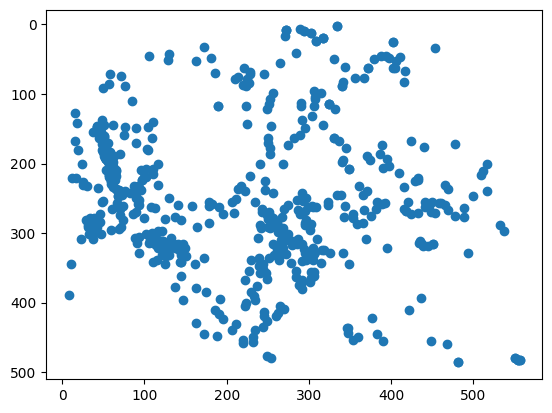

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# CSVファイルを読み込む
df = pd.read_csv(f'{inputfile}')

# 条件に合致する行を抽出する
filtered_df = df[(df['action'] == 'walking') & (df['interactions'] == 'none')]

# x列とy列を取得
x_values = filtered_df['x']
y_values = filtered_df['y']

# プロット
plt.scatter(x_values, y_values)
plt.gca().invert_yaxis()  # y軸を反転する
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Walking with no interactions')
plt.show()
